In [2]:
from setup import proj_dir, out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

from collections import OrderedDict
import os


import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size":12})
%matplotlib inline
from matplotlib.ticker import NullFormatter
import seaborn as sns
import numpy as np
from time import time

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms

import glob
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

from dataloader import image_loader
from M1_util_train_test import load_model
from util_image import inverse_transform
import util_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
model_type = 'SAE'
load_model_name = 'Autoencoder'
zoomlevel = 'zoom15'
output_dim = 1
model_run_date = '22021402'
sampling = 'stratified'
normalization = 'minmax'
data_version = '1571'

variable_names = ['trpgen','active','auto','mas','pt']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
args = {'image_size': 224, 
        'depth': -1,
       'base_channels':64,
       'output_dim':output_dim,
       'num_demo_vars':len(demo_variables),
       'demo_norm': normalization,
       'cardinality':1,
       'epochs':20,
       'batch_size':16,
       'base_lr':0.1,
       'weight_decay':0.0005,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[150,225]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':False}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('input_shape', (1, 3, args['image_size'], args['image_size'])),
    ('output_dim', args['output_dim']),
    ('num_demo_vars', args['num_demo_vars'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size']),
    ('demo_norm', args['demo_norm'])
])

run_config = OrderedDict([
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

# Load Model

In [199]:
# Check one model exists for this config
model_path = glob.glob(model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                       model_run_date+"_*.pt")
#
if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)
    print(model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+model_run_date+"_*.pt")

/mnt/qingyi/image_chicago/models/SAE_zoom13_8192_22021404_145.pt loaded.


In [5]:
# load model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config['model_config'])

config['model_config']['input_shape'] = [1,2048,output_dim,output_dim]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['model_config']['output_channels'] = 3

decoder = load_model(config['model_config']['arch'], 'Decoder', config['model_config'])

config['encoder'] = encoder
config['decoder'] = decoder

model = load_model('autoencoder',load_model_name, config)
model.load_state_dict(saved['model_state_dict']);
model = model.to(device)
model.eval();

In [6]:
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], run_config['num_workers'], 
                                         data_config['image_size'], data_version=data_version,
                                         sampling=sampling, recalculate_normalize=False)


28278 images in dataset
3142 images in dataset


# Encoder Embeddings

In [159]:
# Check if embeddings have been saved
files = glob.glob(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl")

if len(files) == 1:
    print("Loading Existing Embedding", proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl")
    with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f:
        encoder_output = pkl.load(f)
        im = pkl.load(f)
        ct = pkl.load(f)
        
elif len(files) > 1:
    print("Multiple Files exist. Check specified path.")
    
else: # Calculate Embedding
    ct = []
    encoder_output = []
    im = []

    for step, data in enumerate(train_loader):
        data1 = data[1].to(device)
        ct += [s[s.rindex("/")+1: s.rindex("_")]for s in data[0]]
        encoder_output += [encoder(data1).cpu().detach().numpy()]
        im += data[0]
        if step % 10 == 0:
            print(step, end='\t')

    for step, data in enumerate(test_loader):
        data1 = data[1].to(device)
        ct += [s[s.rindex("/")+1: s.rindex("_")]for s in data[0]]
        encoder_output += [encoder(data1).cpu().detach().numpy()]
        im += data[0]
        if step % 10 == 0:
            print(step, end='\t')

    encoder_output = np.vstack(encoder_output)    

#     print(encoder_output.shape)
    encoder_output = encoder_output.reshape(len(encoder_output), -1)

    # Save Embeddings

    with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           model_run_date+".pkl", "wb") as f:
        pkl.dump(encoder_output, f)
        pkl.dump(im, f)
        pkl.dump(ct, f)

Loading Existing Embedding /mnt/qingyi/image_chicago/latent_space/SAE_zoom13_2048_22021402.pkl


# Create perturbed epsilon around existing embeddings
- good quality images can only be obtained from high latent space dimension

In [56]:
n = 20

sample_embedding = encoder_output[:n, :]
embedding_dim = sample_embedding.shape[1]

from torchvision import transforms
for i in range(n): 
    fig, ax = plt.subplots(1,4, figsize=(20,6))
    decoder_in = torch.tensor(sample_embedding[i])
    decoder_in = decoder_in.to(device)
    decoder_in = decoder_in.view(1, -1, output_dim, output_dim)
    reconstruct = decoder(decoder_in)[0]
    reconstruct = inverse_transform(reconstruct.cpu())

    im = transforms.ToPILImage()(reconstruct).convert("RGB")
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[0].set_title("Original")
    
    for e in range(3,0,-1):
        decoder_in = torch.tensor(sample_embedding[i])
        epsilon = torch.normal(0, 10**(-e), size = (output_dim,)).view(-1)
        decoder_in += epsilon

        decoder_in = decoder_in.view(1, -1, output_dim, output_dim)
        decoder_in = decoder_in.to(device)
        reconstruct = decoder(decoder_in)[0]
        reconstruct = inverse_transform(reconstruct.cpu())

        im = transforms.ToPILImage()(reconstruct).convert("RGB")
        ax[4-e].imshow(im)
        ax[4-e].axis('off')
        ax[4-e].set_title(str(10**(3-e))+"%")
    
    fig.savefig(out_dir+"image_samples/latent_perturb/"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+ct[i]+".png")


# Aggregate Embeddings

In [160]:
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Latent Space Visualization with tSNE

In [161]:
# check if tSNE is already done
tsne_file = glob.glob(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+model_run_date+".csv")

In [163]:
if len(tsne_file) != 0:
    df_ct = pd.read_csv(tsne_file[0])
else:
    from sklearn import manifold
    method = manifold.TSNE(n_components=2, init='pca', random_state=42)
    t0 = time()
    # tsne_im = method.fit_transform(encoder_output)
    tsne_ct = method.fit_transform(aggregate_embeddings)
    t1 = time()
    print("tSNE Running time %s: %d sec" % ('Time', t1 - t0))

    demo_df = pd.read_csv(data_dir+"demo_tract.csv")
    demo_df['pop_density'] = demo_df['tot_population'] / demo_df['area']
    demo_df['COUNTYA'] = demo_df['COUNTYA'].astype('str')

    # tSNE done on individual images
    # df_im = pd.DataFrame(tsne_im, columns = ['x0', 'x1'])
    # df_im['geoid'] = ct
    # df_im = pd.merge(df_im, demo_df, on='geoid')

    # tSNE done on aggregate embeddings
    df_ct = pd.DataFrame(tsne_ct, columns = ['x0', 'x1'])
    df_ct['geoid'] = unique_ct

    df_ct = pd.merge(df_ct, demo_df, on='geoid')

    print(df_ct.columns.tolist())

    df_ct['pop_density'] /= 1000
    df_ct['inc_per_capita'] /= 1000
    df_ct['pct_adult'] = df_ct['pct25_34yrs']+df_ct['pct35_50yrs']
    df_ct['pct_senior'] = df_ct['pctover65yrs']

In [52]:
# density plot
# ax = sns.jointplot(x=df_im["x0"].to_numpy(), y=df_im["x1"].to_numpy(), kind='kde', height=3)
# ax.set_axis_labels("", "")
# plt.show()

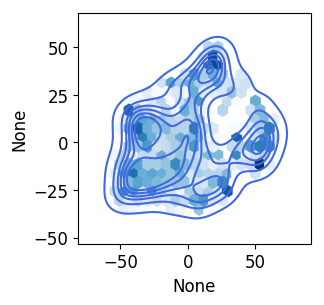

In [188]:
# density plot
fig, ax = plt.subplots(1,1,figsize=(3,3))
hexagons = ax.hexbin(df_ct["x0"].to_numpy(), df_ct["x1"].to_numpy(), gridsize=17, mincnt=1, cmap='Blues')
sns.kdeplot(x=df_ct["x0"].to_numpy(), y=df_ct["x1"].to_numpy(), ax=ax, levels=7, color='royalblue')
# ax.axis('off')
# fig.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
#                        model_run_date+"_density.png", bbox_inches='tight')
plt.show()

In [180]:
a = pd.DataFrame(np.concatenate([hexagons.get_offsets(), hexagons.get_array().reshape(-1,1)], axis=1), columns=['x0','x1','num'])

In [184]:
a = a.sort_values(by='num', ascending=False)

In [232]:
c1 = "17_31_540102"
c2 = "17_43_846413"
c3 = "17_31_221200"
c4 = "17_31_610300"
c5 = "17_197_883305"

In [233]:
df_ct[df_ct['geoid'].isin([c1, c2, c3, c4, c5])]

,geoid,COUNTYA,TRACTA,x0,x1,kmeans
139,17_197_883305,197,883305,-25.798365,1.775957,0
276,17_31_221200,31,221200,56.987520,-10.395994,1
477,17_31_540102,31,540102,12.031525,40.679043,2
502,17_31_610300,31,610300,24.724216,-21.349120,3
1327,17_43_846413,43,846413,-20.444662,-15.872024,4


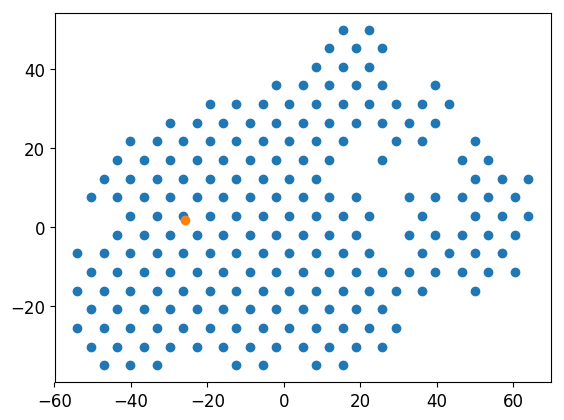

In [229]:
ct_sample = df_ct.sample(1)

plt.scatter(a['x0'], a['x1'])
# plt.scatter(a.head(9)['x0'], a.head(9)['x1'])
plt.scatter(ct_sample['x0'], ct_sample['x1'])
plt.show()

In [225]:
def plot_hex(var, cmap):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    im = ax.hexbin(df_ct["x0"].to_numpy(), df_ct["x1"].to_numpy(), C=df_ct[var], gridsize=17, cmap=cmap)
    cax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
    fig.colorbar(im, cax=cax)
    ax.axis('off')
    fig.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           model_run_date+"_"+var+".png", bbox_inches='tight')
    return fig

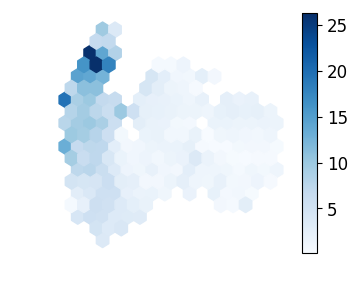

In [145]:
plot_hex('pop_density', 'Blues');
plt.show()

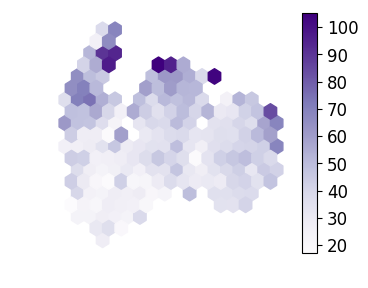

In [146]:
plot_hex('inc_per_capita', 'Purples');
plt.show()

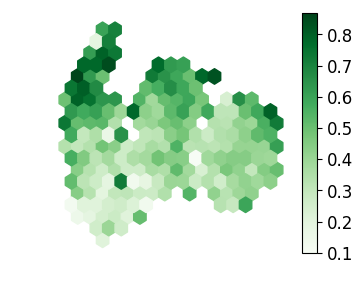

In [147]:
plot_hex('pct_col_grad', 'Greens');
plt.show()

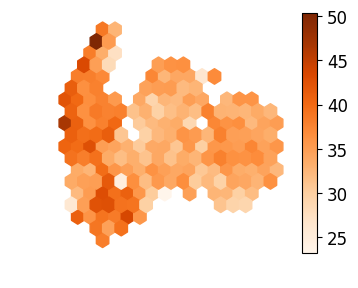

In [148]:
plot_hex('avg_tt_to_work', 'Oranges');
plt.show()

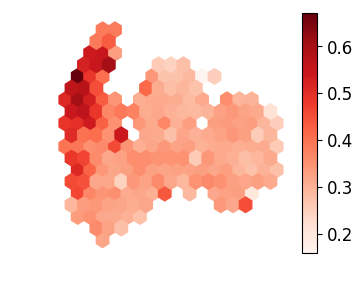

In [149]:
plot_hex('pct_adult', 'Reds');
plt.show()

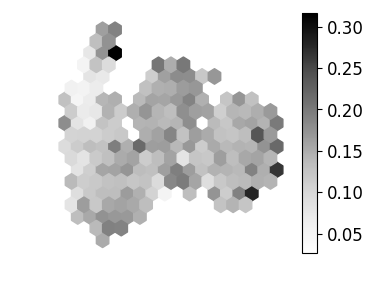

In [150]:
plot_hex('pct_senior', 'Greys');
plt.show()

# Latent Space Clustering

In [96]:
# DBSCAN does not really work
# from scipy.spatial import distance
# d = []
# for i in range(10000):
#     a = np.random.randint(0, 7410)
#     b = np.random.randint(0, 7410)
#     d.append(distance.euclidean(encoder_output[a], encoder_output[b]))
# plt.hist(d)
# plt.show()
# from sklearn.cluster import DBSCAN
# clustering = DBSCAN(eps=1.75, min_samples=10).fit(encoder_output)
# pd.Series(clustering.labels_).value_counts()

In [151]:
from sklearn.cluster import KMeans

kmeans_ct = KMeans(n_clusters=5)
kmeans_ct.fit(aggregate_embeddings)
df_ct['kmeans'] = kmeans_ct.labels_
pd.Series(kmeans_ct.labels_).value_counts()


2    460
1    442
3    260
4    205
0    204
dtype: int64

In [189]:
# kmeans_im = KMeans(n_clusters=5)
# kmeans_im.fit(encoder_output)
# df_im['kmeans'] = kmeans_im.labels_
# pd.Series(kmeans_im.labels_).value_counts()


In [21]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
 

In [152]:
shp = gpd.read_file(data_dir+"tl_2018_17_tract/tl_2018_17_tract.shp")

shp['geoid'] = shp['STATEFP'].astype(str)+'_'+shp['COUNTYFP'].str.lstrip('0')+'_'+shp['TRACTCE'].str.lstrip('0')
# shp['geometry'] = shp['geometry'].to_crs('epsg:26916')

f = pd.read_csv(data_dir+"census_tracts_filtered-"+data_version+".csv")

shp_f = pd.merge(shp, f, on='geoid')

shp_ct = pd.merge(shp, df_ct, on='geoid')

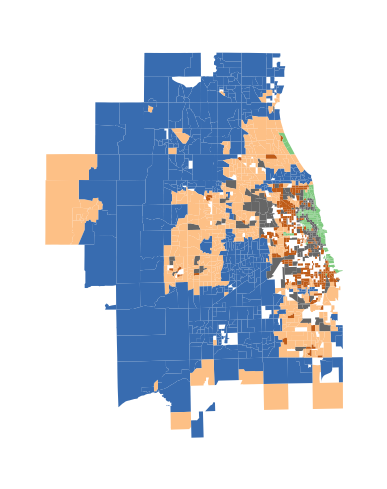

In [153]:
gplt.choropleth(shp_ct, hue='kmeans', edgecolor='None', projection=gcrs.AlbersEqualArea(), cmap='Accent')
plt.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           model_run_date+"_kmeans_all.png", bbox_inches='tight')
plt.show()

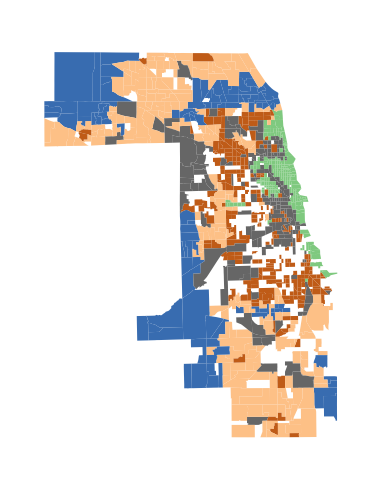

In [154]:
gplt.choropleth(shp_ct[shp_ct['COUNTYFP']=='031'], hue='kmeans', edgecolor='None', projection=gcrs.AlbersEqualArea(), cmap='Accent')
plt.savefig(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           model_run_date+"_kmeans_cook.png", bbox_inches='tight')
plt.show()

In [155]:
df_ct[['geoid','COUNTYA','TRACTA', 'x0','x1','kmeans']].to_csv(out_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           model_run_date+".csv", index=False)

In [104]:
shp_f['train_test'] = 1-shp_f['train_test']

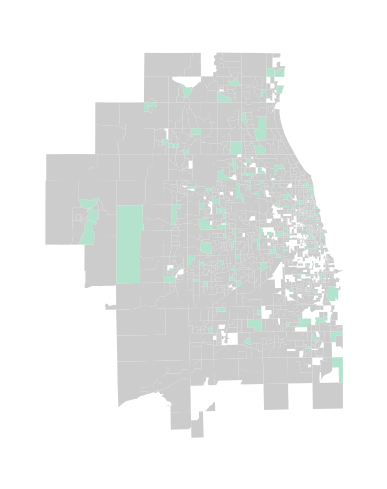

In [105]:
gplt.choropleth(shp_f, hue='train_test', projection=gcrs.AlbersEqualArea(),cmap='Pastel2')
plt.show()

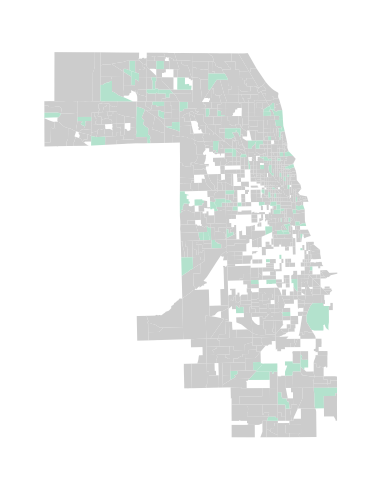

In [106]:
gplt.choropleth(shp_f[shp_f['COUNTYFP']=='031'], hue='train_test', projection=gcrs.AlbersEqualArea(),cmap='Pastel2')
plt.show()